# This is a demo of outlier detection in Python

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn import linear_model as linmod

DEBUGGING = False

if DEBUGGING: np.random.seed(0)
#print (np.random.seed())


Define a function to detect outliers using Tukey's nonparametric (IQR) method

In [2]:
'''
Using Tukey's IQR method, identify outlier indices in data.  
It will return the whiskers and a dictionary containing high and low outliers.  The keys are 'hi' and 'lo'
Make sure the whiskers stay within the (min_possible, max_possible) interval
if it is defined.   
'''
def FindOutlierIndices(data, beta = 1.5, min_possible = float('nan'), max_possible = float('nan')):
  q1q3 = np.percentile(data, (25, 75))
  iqr = np.diff(q1q3)
  hw = q1q3[1] + beta * iqr
  lw = q1q3[0] - beta * iqr

  if not np.isnan(min_possible): lw = max (lw, min_possible)
  if not np.isnan(max_possible): hw = min (hw, max_possible)

  hi = np.where (data > hw)
  lo = np.where (data < lw)

  if DEBUGGING:
    print q1q3
    print iqr
    print "lw = ", lw, ";  hw = ", hw
    plt.boxplot (data, sym = "*")
    plt.show()

  retDict = {'hi': hi[0], "lo": lo[0]}
  return lw, hw, retDict

Generate a data set to use with this function

Identified 0 low and 35 high outliers


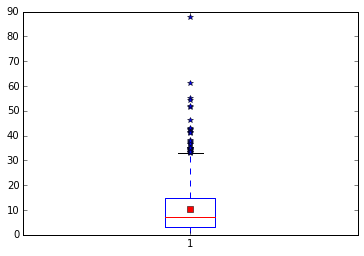

In [4]:
'''Generate exponentially distributed random numbers'''
thedata = np.random.exponential(10, 1000)

'''Identify the outlier indices'''
lw, hw, theOLs = FindOutlierIndices(thedata)
print "Identified %d low and %d high outliers" % (len(theOLs.get('lo')), len(theOLs.get('hi')))

'''Show the data (boxplot)'''
plt.boxplot (thedata,sym = '*', showmeans = True)
plt.show()

See how outlier detection works with regression:

Create a linearly-correlated pair of data sets (X and Y)

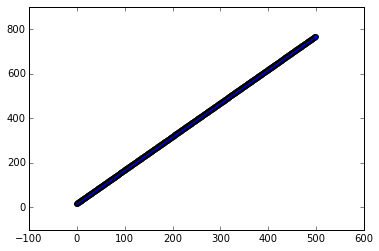

In [5]:
#####################################################################################################################
'''Create an (X, Y) pair for regression analysis'''
X = np.arange (0., 500., 0.5)
Y = 1.5 * X + 15

plt.plot (X, Y)
plt.scatter(X, Y)
plt.show()

In [6]:
#####################################################################################################################
'''Add some noise'''
Y_fuzzy = Y + 50*thedata

#####################################################################################################################
'''Fit linear regression'''
lr = linmod.LinearRegression()
lr.fit (X[:,np.newaxis], Y_fuzzy[:,np.newaxis])
X_test = X
mdlPrediction = lr.predict (X_test[:,np.newaxis]).flatten()

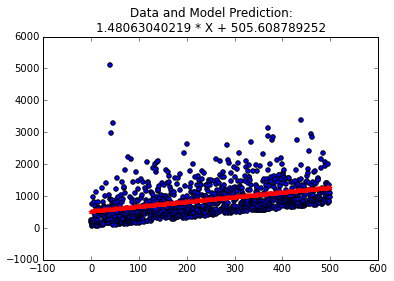

In [34]:
#####################################################################################################################
'''Show fuzzy data and regression line'''
plt.scatter(X, Y_fuzzy, marker = 'o')
plt.scatter(X_test, mdlPrediction, color='red',marker='*', linewidths=0.5)
plt.title('Data and Model Prediction: \n' + str(lr.coef_[0][0]) + " * X + " + str(lr.intercept_[0]))
plt.show()

In [7]:
#####################################################################################################################
'''Compute residuals'''
myResid = Y_fuzzy - mdlPrediction
# print myResid
# print X_test

Visually Analyze the residuals

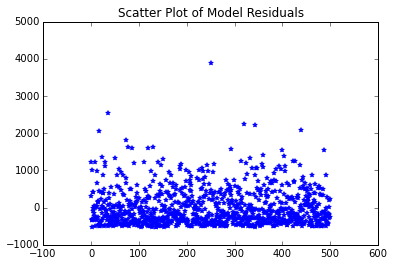

In [8]:
#####################################################################################################################
'''Scatter Plot to see trends and estimate density'''
plt.scatter (X_test, myResid, marker = '*', color = 'blue')
plt.title ("Scatter Plot of Model Residuals")
plt.show()

There does not seem to be a trend in residuals; let us see if we have outliers

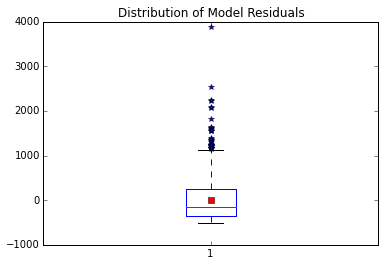

In [9]:
#####################################################################################################################
'''Box Plot to see the three quartiles, the mean, and the outliers'''
plt.boxplot (myResid, sym = "*",showmeans=True)
plt.title ("Distribution of Model Residuals")
plt.show()


In [10]:
#####################################################################################################################
'''Detect outliers in Residuals'''
residLW, residHW, residOLs = FindOutlierIndices(myResid)
print "residLW = %3.2f; residHW = %3.2f" % (residLW, residHW)
print "Identified %d low and %d high outliers" % (len(residOLs.get('lo')), len(residOLs.get('hi')))

residLW = -1261.08; residHW = 1141.02
Identified 0 low and 35 high outliers


Can we show outlier lines on the residuals plot?

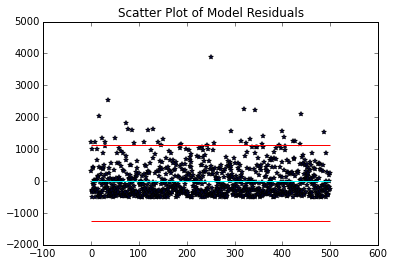

In [11]:
'''Show residuals and outlier lines'''
plt.scatter (X_test, myResid, marker = '*')
plt.title ("Scatter Plot of Model Residuals")
plt.hlines(residHW, min(X_test), max(X_test), colors="red")
plt.hlines(residLW, min(X_test), max(X_test), colors="red")
plt.hlines(0, min(X_test), max(X_test), colors="cyan")

plt.show()

We have a problem: the residuals around a linear-regression (OLS) line want to stay symmetrically distributed, leading to this:

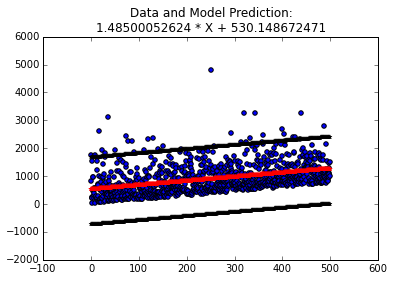

In [12]:
'''Show fuzzy data, regression line, and outliers'''
hiOLline = mdlPrediction + residHW
loOLline = mdlPrediction + residLW

plt.scatter(X, Y_fuzzy, marker = 'o')
plt.scatter(X_test, mdlPrediction, color='red',marker='*', linewidths=0.5)
plt.title('Data and Model Prediction: \n' + str(lr.coef_[0][0]) + " * X + " + str(lr.intercept_[0]))
plt.scatter(X_test, hiOLline, color='black',marker='*', linewidths=0.125)
plt.scatter(X_test, loOLline, color='black',marker='*', linewidths=0.125)

plt.show()

Enter QuantReg

First we need to add another bunch of libraries

In [15]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

Now we can build a DataFrame to keep the X and the Y_fuzzy

In [17]:
#################################################################################################################
myData = pd.DataFrame({'X':X, 'Y_fuzzy':Y_fuzzy})
print myData.head(7)

     X      Y_fuzzy
0  0.0   838.521662
1  0.5  1766.394190
2  1.0   237.180559
3  1.5   202.282311
4  2.0  1540.525348
5  2.5   209.473578
6  3.0    26.217487


In [99]:
#################################################################################################################
''' And now we can go into quantile regression '''
qntlRegr = smf.quantreg('Y_fuzzy ~ X', data=myData)
Probs = (0.05, 0.25,0.50,0.75, 0.95)
qrMdls = []
qrPred = []
qrPredDict = {}
for ii in range (0,len(Probs)):
    qrMdls.append(qntlRegr.fit(q=Probs[ii]))
    if DEBUGGING: print Probs[ii]
    myQR = qrMdls[ii]
    if DEBUGGING: print myQR.summary()
    qrPred.append (myQR.predict ())
    qrPredDict[str(Probs[ii])] = myQR.predict()
    
qrPredDF = pd.DataFrame(qrPredDict)

qrPredDF.columns = ['p'+ str (int (pp*100)) for pp in Probs]
qrPredDF.head(7)

C:\Anaconda\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)


,p5,p25,p50,p75,p95
0,38.336865,167.341487,352.772101,728.017972,1657.072822
1,39.089143,168.087711,353.553818,728.835183,1657.565595
2,39.841422,168.833936,354.335536,729.652394,1658.058368
3,40.593701,169.580161,355.117254,730.469604,1658.551141
4,41.345979,170.326385,355.898971,731.286815,1659.043914
5,42.098258,171.072610,356.680689,732.104026,1659.536687
6,42.850537,171.818835,357.462407,732.921236,1660.029460


Compute IQR and whiskers for each row in qrPredDF

In [100]:
qrPredDF['iqr'] = qrPredDF['p75'] - qrPredDF['p25']
lW = qrPredDF['p25'] - 1.5*qrPredDF['iqr']
low_whiskers = ()
for lll in lW:
    if lll > 0:
        low_whiskers = lll
    else:
        low_whiskers = 0
qrPredDF['lower'] = low_whiskers
qrPredDF['upper'] = qrPredDF['p75'] + 1.5*qrPredDF['iqr']
qrPredDF.head(7)

,p5,p25,p50,p75,p95,iqr,lower,upper
0,38.336865,167.341487,352.772101,728.017972,1657.072822,560.676486,0,1569.032701
1,39.089143,168.087711,353.553818,728.835183,1657.565595,560.747472,0,1569.956390
2,39.841422,168.833936,354.335536,729.652394,1658.058368,560.818458,0,1570.880080
3,40.593701,169.580161,355.117254,730.469604,1658.551141,560.889444,0,1571.803770
4,41.345979,170.326385,355.898971,731.286815,1659.043914,560.960430,0,1572.727459
5,42.098258,171.072610,356.680689,732.104026,1659.536687,561.031416,0,1573.651149
6,42.850537,171.818835,357.462407,732.921236,1660.029460,561.102402,0,1574.574838


Show the plot for each column of qrPredDF

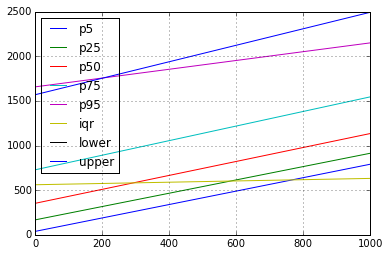

In [101]:
qrPredDF.plot()
plt.show()

Note that the upper bound and the p95 lines are not parallel.  This is not unexpected: the upper bound is calculated as a function of p25, p75, and IQR.  Because IQR = const, upper bound is parallel to p25 and p75 lines, but p95 may very well have its own trajectory, depending on the data.


Remove the 'iqr' column

In [102]:
del qrPredDF['iqr']

show the plot again, this time with the data:

In [106]:
uPper = qrPredDF['upper']
yMax= np.max(uPper + Y_fuzzy)
qrMdlDF =qrPredDF[:500]

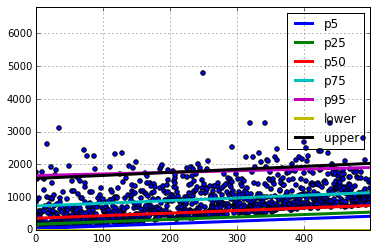

In [108]:
qrMdlDF.plot(linewidth = 3.0)
plt.scatter(X, Y_fuzzy, marker = 'o')
plt.ylim(ymin=0, ymax = yMax)

plt.show()

Points above the black line ("upper") are high outliers.  The red line is the median.  Note that p95 and upper bound, in this case, are very close.  Also note that the lower part of distribution is much more compacted (we are dealing with a right-skewed distribution - as expected).  Finally, there is no yellow ("lower" line): we forced the lower bound to be non-negative.